## Prediction heatmaps
The gold standard & different models are the columns, and the words in the gold standard are the rows. Here, I'll experiment with different groupsings of the rows to help visualize what, if any, the differences are in the types of entities that the models tend to predict.

I'll make separate plots for unigrams, bigrams, and trigrams.

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [21]:
import jsonlines
import pandas as pd
import numpy as np

In [3]:
data = {'gold_std':'../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/all_gold_standard_abstracts_GOLD_STD_10Jan2022.jsonl',
       'dygiepp_ace05':'../data/straying_off_topic_data/dygiepp/pretrained_output/lightweight/ace05/all_gold_standard_abstracts_10Jan2022_ace05_predictions.jsonl',
       'dygiepp_scierc_light':'../data/straying_off_topic_data/dygiepp/pretrained_output/lightweight/scierc-light/all_gold_standard_abstracts_10Jan2022_scierc-light_predictions.jsonl',
       'dygiepp_genia_light':'../data/straying_off_topic_data/dygiepp/pretrained_output/lightweight/genia-light/all_gold_standard_abstracts_10Jan2022_genia-light_predictions.jsonl',
       'dygiepp_genia':'../data/straying_off_topic_data/dygiepp/pretrained_output/withCoref/genia/all_gold_standard_abstracts_10Jan2022_genia_predictions.jsonl',
       'dygiepp_scierc':'../data/straying_off_topic_data/dygiepp/pretrained_output/withCoref/scierc/all_gold_standard_abstracts_10Jan2022_scierc_predictions.jsonl',
       'phrasematched_plain':'../data/straying_off_topic_data/model_output/keyword_match/phrasematch_plain/all_gold_10Jan2022_phrasematched_plain_dygiepp_format.jsonl',
       'phrasematched_refined':'../data/straying_off_topic_data/model_output/keyword_match/phrasematch_refined/all_gold_10Jan2022_phrasematched_refined_dygiepp_format.jsonl',
       'pure_ace05':'../data/straying_off_topic_data/model_output/pure/ace05/ent-alb-ctx100/ace05_ent_pred_dev.json',
       'pure_scierc':'../data/straying_off_topic_data/model_output/pure/scierc/ent-scib-ctx300/scierc_ent_pred_dev.json'}

First, need to affirm that the documents in all prediction sets are in the same order:

In [11]:
# Read in all datasets
for name, filepath in data.items():
    contents = []
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            contents.append(obj)
    data[name] = contents

In [14]:
# Reorder based on value of "doc_key" so they're all in the same order
for name, dataset in data.items():
    sorted_dataset = sorted(dataset, key=lambda d: d['doc_key'])
    data[name] = sorted_dataset

In [15]:
# Check that it worked
for name, dataset in data.items():
    print(dataset[0]['doc_key'])

PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract
PMID1161793_abstract


Get a list of words to be the y-axis:

In [16]:
words = [] 
words_per_doc = [] # Each internal list is a document
for d in data['gold_std']:
    for sent in d['sentences']:
        doc_words = []
        for word in sent:
            words.append(word)
            doc_words.append(word)
        words_per_doc.append(doc_words)

In [17]:
len(words)

14240

Now, we have to get which words are annotated for each model. Writing a function to accomplish this:

In [28]:
def get_annotated_words(words, words_per_doc, model_output, gram_len, pred):
    """
    Get the column for a model for a heatmap.
    
    parameters:
    words, list of str: One list of all words in corpus
        words_per_doc, nested list: Each internal list is the words for one doc
        model_output, list of dict: The json dicts for the models' predictions
        gram_len, int between 1-3: what number of n-gram to check
        pred, bool: True if there are predictions, False if it's the gold standard
        
    returns: 
        annotations, list: values are 0 if the word was not annotated, 1 if it was
    """
    # Initialize an array for annotations
    annotations = np.zeros((len(words)))
    
    if pred:
        key = 'predicted_ner'
    else:
        key = 'ner'
    
    prev_words = 0
    for wordlist, doc_json in zip(words_per_doc, model_output):
        for sent in doc_json[key]:
            for anno in sent:
                if gram_len == 1:
                    if anno[0] == anno[1]:
                        annotated_idx = prev_words + anno[0]
                        annotations[annotated_idx] = 1.0
                if gram_len == 2:
                    if anno[0] == anno[1]-1:
                        annotated_idx_start = prev_words + anno[0]
                        annotated_idx_end = annotated_idx_start + 2
                        annotations[annotated_idx_start:annotated_idx_end] = 1.0
                if gram_len == 3:
                    if anno[0] == anno[1]-2:
                        annotated_idx_start = prev_words + anno[0]
                        annotated_idx_end = annotated_idx_start + 3
                        annotations[annotated_idx_start:annotated_idx_end] = 1.0
        prev_words += len(wordlist)-1
                        
    return list(annotations)

In [24]:
# Quick test
test_words = ['hello', 'world', 'I', 'am', 'Sparty']
test_words_per_doc = [['hello', 'world'], ['I', 'am', 'Sparty']]
test_model_output = [{'predicted_ner':[[[0, 0], [0, 1]],[[2,4]]]}]

In [29]:
get_annotated_words(test_words, test_words_per_doc, test_model_output, 1, True)

[1.0, 0.0, 0.0, 0.0, 0.0]

In [30]:
get_annotated_words(test_words, test_words_per_doc, test_model_output, 2, True)

[1.0, 1.0, 0.0, 0.0, 0.0]

In [31]:
get_annotated_words(test_words, test_words_per_doc, test_model_output, 3, True)

[0.0, 0.0, 1.0, 1.0, 1.0]

Passed the test! Now do it for real data:

In [38]:
unigram_cols = {}
for name, dataset in data.items():
    if name == 'gold_std':
        col = get_annotated_words(words, words_per_doc, dataset, 1, False)
        unigram_cols[name] = col
    else:
        col = get_annotated_words(words, words_per_doc, dataset, 1, True)
        unigram_cols[name] = col

In [39]:
bigram_cols = {}
for name, dataset in data.items():
    if name == 'gold_std':
        col = get_annotated_words(words, words_per_doc, dataset, 2, False)
        bigram_cols[name] = col
    else:
        col = get_annotated_words(words, words_per_doc, dataset, 2, True)
        bigram_cols[name] = col

In [40]:
trigram_cols = {}
for name, dataset in data.items():
    if name == 'gold_std':
        col = get_annotated_words(words, words_per_doc, dataset, 3, False)
        trigram_cols[name] = col
    else:
        col = get_annotated_words(words, words_per_doc, dataset, 3, True)
        trigram_cols[name] = col

Make dataframes:

In [41]:
unigram_map = pd.DataFrame(unigram_cols, index=words)
unigram_map.head()

,gold_std,dygiepp_ace05,dygiepp_scierc_light,dygiepp_genia_light,dygiepp_genia,dygiepp_scierc,phrasematched_plain,phrasematched_refined,pure_ace05,pure_scierc
Solanum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laciniatum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
bigram_map = pd.DataFrame(bigram_cols, index=words)
bigram_map.head()

,gold_std,dygiepp_ace05,dygiepp_scierc_light,dygiepp_genia_light,dygiepp_genia,dygiepp_scierc,phrasematched_plain,phrasematched_refined,pure_ace05,pure_scierc
Solanum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laciniatum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
trigram_map = pd.DataFrame(trigram_cols, index=words)
trigram_map.head()

,gold_std,dygiepp_ace05,dygiepp_scierc_light,dygiepp_genia_light,dygiepp_genia,dygiepp_scierc,phrasematched_plain,phrasematched_refined,pure_ace05,pure_scierc
Solanum,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
laciniatum,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Aiton,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
treated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
with,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now make heatmaps from these dataframes:

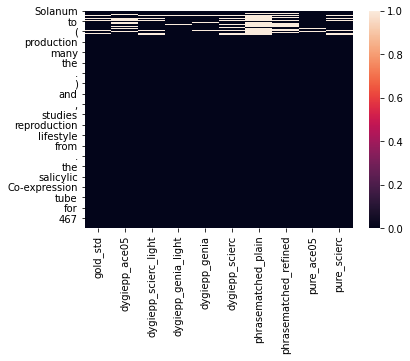

In [48]:
ax = sns.heatmap(unigram_map)

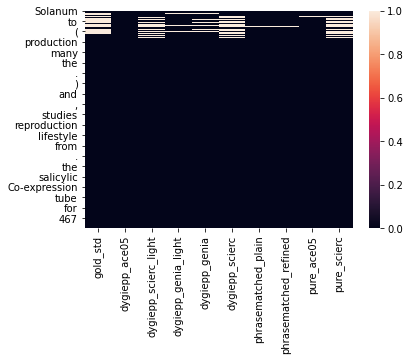

In [49]:
ax = sns.heatmap(bigram_map)

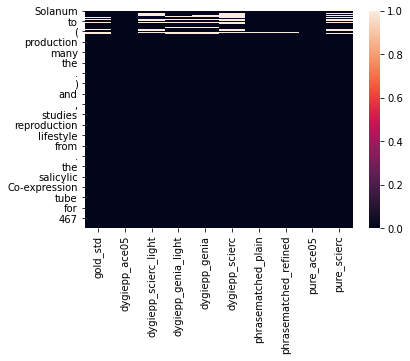

In [50]:
ax = sns.heatmap(trigram_map)